In [2]:
# imports

# Models
from sklearn.base import BaseEstimator, TransformerMixin

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier as lgbm
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE 

# pipelines
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline

# preprocessors
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler
from sklearn.feature_selection import chi2, f_classif, mutual_info_classif, SelectKBest, SelectFromModel, RFE

# Samplers
from imblearn.combine import SMOTEENN, SMOTETomek
from imblearn.over_sampling import SMOTE

# Imputers
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import KNNImputer, IterativeImputer
import miceforest as mf

# metrics and splitters
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_auc_score

from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.model_selection import train_test_split

# utils
from sklearn.utils.validation import check_is_fitted
from sklearn.utils.class_weight import compute_class_weight
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pickle
import sys
import matplotlib_venn as venn
import random

# progress bar
from ipywidgets import IntProgress
from IPython.display import display

sys.path.append("../")

import utils_ML as uml

In [3]:
data = pd.read_csv("../PEMatrix/norm_NSAF_data2.csv", index_col = "assay_id")
meta = pd.read_csv("../../Metadata/unified_metadata.csv")
meta = meta[meta.assay_id.isin(data.index)]

groups = pd.read_csv("../../Metadata/group_cells_annotation.csv", sep =";", index_col="Unnamed: 0")
meta["Group"] = meta.cell_line.apply(lambda x: groups[groups.cell_line == x]["group"].values[0])
meta = meta.set_index("assay_id")

target_encoder = LabelEncoder()
targets = target_encoder.fit_transform(meta.Group)
unique_labels = pd.Series(targets).unique()
class_weights = compute_class_weight(class_weight='balanced', classes=unique_labels, y=targets)

weights = {unique_labels[i]: class_weights[i] for i in range(len(unique_labels))}
print(weights)

data.sort_index(inplace=True)
meta.sort_index(inplace=True)

{2: 2.6564102564102563, 7: 3.453333333333333, 9: 0.7194444444444444, 1: 0.3453333333333333, 0: 0.4427350427350427, 8: 1.5014492753623188, 14: 3.453333333333333, 6: 0.5755555555555556, 3: 2.3022222222222224, 11: 1.3282051282051281, 5: 1.4388888888888889, 12: 1.4388888888888889, 10: 1.3282051282051281, 4: 0.8222222222222222, 13: 1.817543859649123}


In [44]:
filtering = uml.FilterByOccurence(percentage=.2)
imputer = uml.LowestValueImputer()
scaler = MinMaxScaler()

preprocessor = Pipeline(steps=[
    ('imputer', imputer),
    ('scaler', scaler)
])

processed_data = preprocessor.fit_transform(data)

In [46]:
processed_data = pd.DataFrame(processed_data)

/home/compomics/miniconda3/envs/ionbot/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/home/compomics/miniconda3/envs/ionbot/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


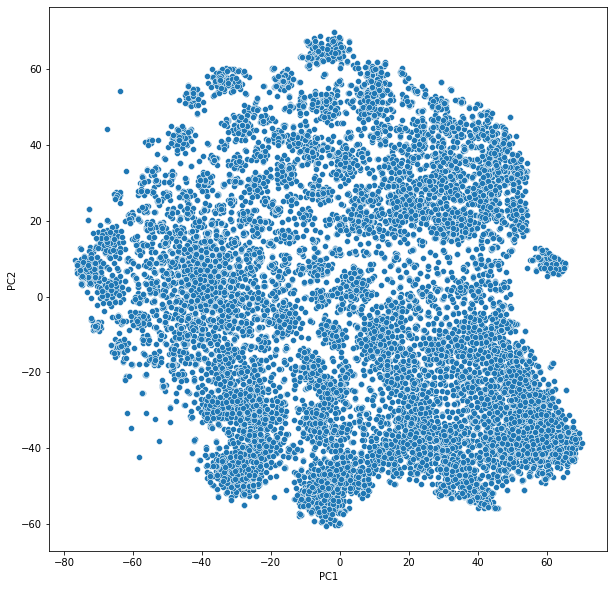

In [49]:
plt.figure(figsize=(10,10))

pca = TSNE(perplexity=20)

embedding = pca.fit_transform(processed_data.T)
sns.scatterplot(data=pd.DataFrame(embedding, columns = ["PC1", "PC2"]), x= "PC1", y = "PC2")

# 3 types of imputation are compared

- Lowest value imputation
- RFimpute
- KNNimpute

In [4]:
preprocessor = Pipeline(steps=[
    ('filtering', uml.FilterByOccurence(.75)),
    ('imputer', KNNImputer(weights='distance')),
    ('scaler', MinMaxScaler())
])

In [5]:
imputedKNN_data = preprocessor.fit_transform(data)

In [6]:
imputedKNN_data = pd.DataFrame(imputedKNN_data, columns = preprocessor.named_steps.filtering.filtered_proteins)

In [8]:
f = IntProgress(min=0, max= 5 * 6) # splits * preprocessors * oversampling methods * models
display(f)

skf = StratifiedKFold(n_splits=5, shuffle=True)

fold = 0
for train, test in skf.split(X = data, y = targets):
    
    fold += 1
    # Split data
    X_train = data.iloc[train,:]
    Y_train = targets[train]
    X_test = data.iloc[test,:]
    Y_test = targets[test]

    # Try [.2, .4, .5, .6, .75, .9] filtering
    for filter_percentage in [.2, .4, .5, .6, .75, .9]:
        filtering = uml.FilterByOccurence(percentage=filter_percentage)
        imputer = KNNImputer(weights='distance')
        scaler = MinMaxScaler()

        preprocessor = Pipeline(steps=[
            ('filtering', filtering),
            ('imputer', imputer),
            ('scaler', scaler)
        ])

        # Preprocess the data
        preprocessor.fit(X_train)
        X_train_preprocessed = preprocessor.transform(X_train)
        X_test_preprocessed = preprocessor.transform(X_test)

        X_oversampled, Y_oversampled = SMOTETomek().fit_resample(X_train_preprocessed, Y_train)

        model = LogisticRegression(max_iter=10000)
            
        model.fit(X_oversampled, Y_oversampled)
        Y_pred = model.predict(X_test_preprocessed)

        micro_f1, macro_f1, weighted_f1, cm = uml.scoring_functions(Y_pred=Y_pred, Y_test=Y_test, labels=unique_labels)
            
        results_df = pd.DataFrame({"model": [type(model).__name__], "fold": [fold], "micro_f1": [micro_f1],
                                        "macro_f1": [macro_f1], "weighted_f1": [weighted_f1] ,"cm": [cm], "filter_type": ["global"],
                                        "filter_percentage": [filter_percentage], "proteins": [len(preprocessor.named_steps.filtering.filtered_proteins)]})
            
        uml.save_results(results_df, "global_filtering_skf_KNNimputation")

        f.value += 1    

IntProgress(value=0, max=30)